In [2]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score


In [3]:
#Load FER2013PLUS Dataset (via Directory Format)

# Paths
train_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'

# Image properties
img_size = (48, 48)
batch_size = 64

# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [4]:
#Display Train/Test/Validation Image Counts

print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)


Train samples: 22712
Validation samples: 5674
Test samples: 7099


In [6]:
#Define Traditional CNN Model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,714,056 (6.54 MB)

 Trainable params: 1,714,056 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Train Model (20 Epochs)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set learning rate (start low to avoid overshooting minima)
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with chosen optimizer and metrics
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to prevent overfitting and dynamically adjust learning rate
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint_keras = ModelCheckpoint(
    "best_model_tradCNN.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

checkpoint_h5 = ModelCheckpoint(
    "best_model_tradCNN.weights.h5", 
    monitor="val_accuracy", 
    save_best_only=True, 
    save_weights_only=True, 
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint_keras, checkpoint_h5]
)



Epoch 1/20
348/355 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.4733 - loss: 1.4667
Epoch 1: val_accuracy improved from -inf to 0.51903, saving model to best_model_tradCNN.keras

Epoch 1: val_accuracy improved from -inf to 0.51903, saving model to best_model_tradCNN.weights.h5
355/355 ━━━━━━━━━━━━━━━━━━━━ 88s 232ms/step - accuracy: 0.4735 - loss: 1.4662 - val_accuracy: 0.5190 - val_loss: 1.4202 - learning_rate: 1.0000e-04
Epoch 2/20
348/355 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4959 - loss: 1.4055
Epoch 2: val_accuracy improved from 0.51903 to 0.53349, saving model to best_model_tradCNN.keras

Epoch 2: val_accuracy improved from 0.51903 to 0.53349, saving model to best_model_tradCNN.weights.h5
355/355 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.4959 - loss: 1.4054 - val_accuracy: 0.5335 - val_loss: 1.3755 - learning_rate: 1.0000e-04
Epoch 3/20
348/355 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5094 - loss: 1.3672
Epoch 3: val_accuracy improved from 0.53349 to 0.

In [15]:
#Evaluate Accuracy (Validation & Test)

# Validation accuracy
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6390 - loss: 1.0244
Validation Accuracy: 63.29%
7099/7099 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5712 - loss: 1.2565
Test Accuracy: 63.50%


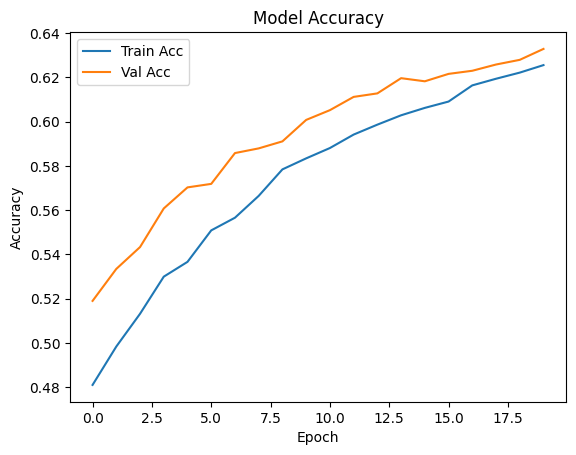

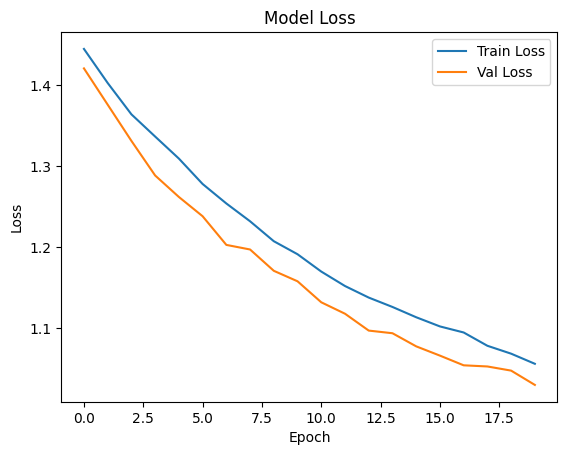

In [16]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [17]:
#Save the Model

model.save('emotion_model_tradCNN_V1.h5')
print("Model saved as emotion_model.h5")


Model saved as emotion_model.h5


Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028729.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Raw prediction output: [[0.1950848  0.00156129 0.00612238 0.01971012 0.65374506 0.01693265
  0.0335986  0.07324507]]
Predicted Emotion: happiness


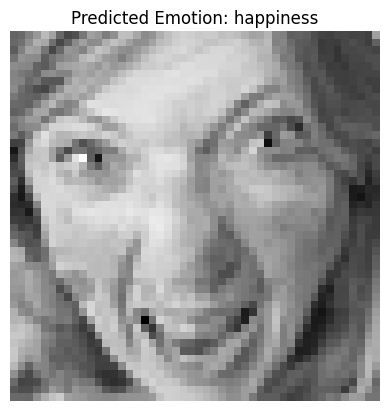

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028729.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)


Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/sadness/fer0028679.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raw prediction output: [[0.01746606 0.00944215 0.00628086 0.04156952 0.19991268 0.40733048
  0.20176518 0.11623303]]
Predicted Emotion: neutral


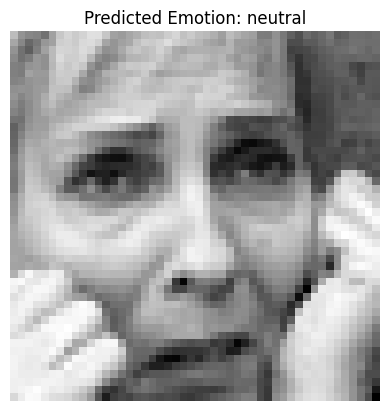

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/sadness/fer0028679.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)
